In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast

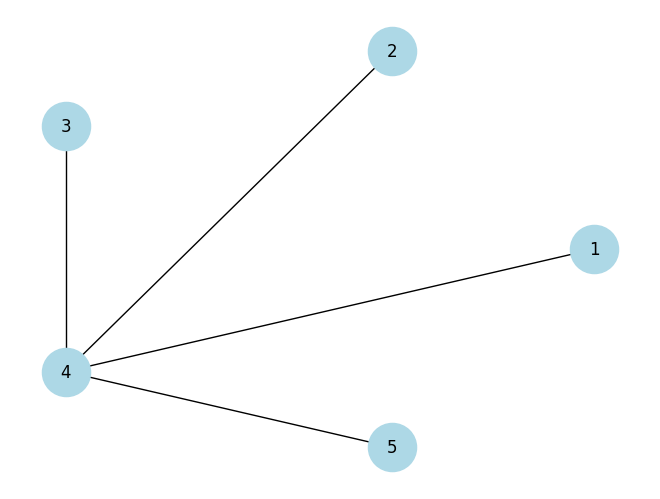

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def create_sisyphus_wheel(n, t):
    """
    Create a Sisyphus wheel graph for a given time step.

    Parameters:
    n (int): The number of nodes in the graph.
    t (int): The time step.

    Returns:
    G (networkx.Graph): The Sisyphus wheel graph at time step t.
    """

    # Create an empty graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(1, n+1))

    # Determine the central node
    central_node = 1 + (-t % (n - 1))

    # Add edges from all nodes to the central node
    for i in range(1, n+1):
        if i != central_node:
            G.add_edge(i, central_node)

    return G

# Test the function
n = 5  # number of nodes
t = 5  # time step
G = create_sisyphus_wheel(n, t)

# Draw the graph
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200)
plt.show()


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def create_sisyphus_wheel(n, t):
    """
    Create a Sisyphus wheel graph for a given time step.

    Parameters:
    n (int): The number of nodes in the graph.
    t (int): The time step.

    Returns:
    G (networkx.Graph): The Sisyphus wheel graph at time step t.
    """

    # Create an empty graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Determine the central node
    central_node = t % n

    # Add edges from all nodes to the central node
    for i in range(n):
        if i != central_node:
            G.add_edge(i, central_node)

    return G

def create_evolving_graph(nodes, T, wheel_size):
    """
    Create an evolving graph where each edge is replaced by a Sisyphus wheel.

    Parameters:
    nodes (list): The nodes of the original directed graph.
    T (int): The number of time steps.
    wheel_size (int): The size of the Sisyphus wheels that replace the edges.

    Returns:
    evolving_graph (list): A sequence of graphs representing the evolving graph.
    """

    # Create a directed graph H with the given nodes and edges that form a cycle
    H = nx.DiGraph()
    H.add_nodes_from(nodes)
    H.add_edges_from([(nodes[i], nodes[(i+1)%len(nodes)]) for i in range(len(nodes))])

    # Create an evolving graph where each edge is replaced by a Sisyphus wheel
    evolving_graph = []
    for t in range(T):
        G_t = nx.Graph()
        for u, v in H.edges:
            # Create a Sisyphus wheel for the edge (u, v)
            wheel = create_sisyphus_wheel(wheel_size, t)
            # Relabel the nodes of the wheel to match the nodes of the original graph
            wheel = nx.relabel_nodes(wheel, {i: f'{u}_{i}' for i in range(wheel_size)})
            # Add the wheel to the graph G_t
            G_t = nx.union(G_t, wheel)

        # Connect the Sisyphus wheels according to the edges in the original graph
        for u, v in H.edges:
            G_t.add_edge(f'{u}_{(t)%wheel_size}', f'{v}_{(t+1)%wheel_size}')

        evolving_graph.append(G_t)

    return evolving_graph

# Test the function
nodes = ['u', 'v', 'w']
T = 3  # number of time steps
wheel_size = 10  # size of the Sisyphus wheels
evolving_graph = create_evolving_graph(nodes, T, wheel_size)

# Draw the graphs
# for t, G_t in enumerate(evolving_graph):
#     plt.figure()
#     plt.title(f'Time step {t}')
#     nx.draw(G_t, with_labels=True, node_color='lightblue', node_size=1200)
# plt.show()


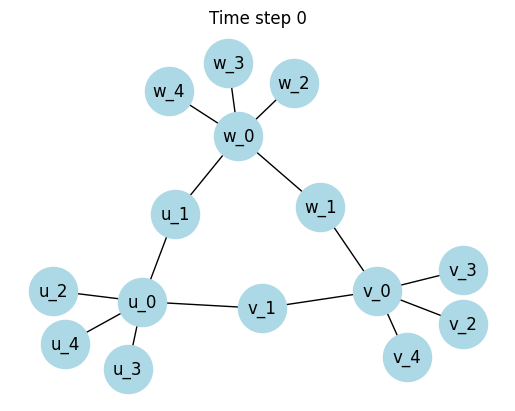

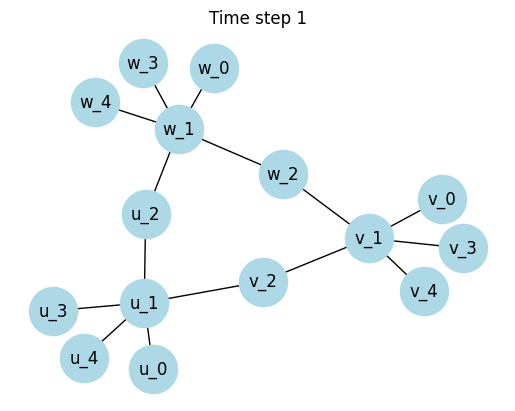

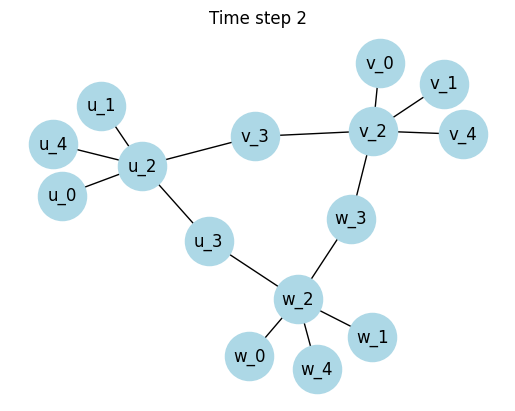

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def create_sisyphus_wheel(n, t):
    """
    Create a Sisyphus wheel graph for a given time step.

    Parameters:
    n (int): The number of nodes in the graph.
    t (int): The time step.

    Returns:
    G (networkx.Graph): The Sisyphus wheel graph at time step t.
    """

    # Create an empty graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Determine the central node
    central_node = t % (n-1)  # The last node never becomes the central node

    # Add edges from all nodes to the central node
    for i in range(n):
        if i != central_node:
            G.add_edge(i, central_node)

    return G

def create_evolving_graph2(nodes, T, wheel_size):
    """
    Create an evolving graph where each edge is replaced by a Sisyphus wheel.

    Parameters:
    nodes (list): The nodes of the original directed graph.
    T (int): The number of time steps.
    wheel_size (int): The size of the Sisyphus wheels that replace the edges.

    Returns:
    evolving_graph (list): A sequence of graphs representing the evolving graph.
    """

    # Create a directed graph H with the given nodes and edges that form a cycle
    H = nx.DiGraph()
    H.add_nodes_from(nodes)
    H.add_edges_from([(nodes[i], nodes[(i+1)%len(nodes)]) for i in range(len(nodes))])

    # Create an evolving graph where each edge is replaced by a Sisyphus wheel
    evolving_graph = []
    for t in range(T):
        G_t = nx.Graph()
        for u, v in H.edges:
            # Create a Sisyphus wheel for the edge (u, v)
            wheel = create_sisyphus_wheel(wheel_size, t)
            # Relabel the nodes of the wheel to match the nodes of the original graph
            wheel = nx.relabel_nodes(wheel, {i: f'{u}_{i}' for i in range(wheel_size)})
            # Add the wheel to the graph G_t
            G_t = nx.union(G_t, wheel)

        # Connect the Sisyphus wheels according to the edges in the original graph
        for u, v in H.edges:
            G_t.add_edge(f'{u}_{(t)%(wheel_size-1)}', f'{v}_{(t+1)%(wheel_size-1)}')

        evolving_graph.append(G_t)

    return evolving_graph

# Test the function
nodes = ['u', 'v', 'w']
T =3  # number of time steps
wheel_size = 5  # size of the Sisyphus wheels
evolving_graph = create_evolving_graph(nodes, T, wheel_size)

for t, G_t in enumerate(evolving_graph):
    plt.figure()
    plt.title(f'Time step {t}')
    nx.draw(G_t, with_labels=True, node_color='lightblue', node_size=1200)
plt.show()


In [5]:
def random_walk_evolving(evolving_graph, start_node, num_steps=10, num_walks=1):
    """
    Perform a random walk over an evolving graph.

    Parameters:
    evolving_graph (list): A sequence of graphs representing the evolving graph.
    start_node (str): The node where the random walk starts.
    num_steps (int): The number of steps in each random walk.
    num_walks (int): The number of random walks to perform.

    Returns:
    walks (list): A list of random walks.
    """

    walks = []
    for _ in range(num_walks):
        walk = [start_node]
        for t in range(num_steps):
            # Get the graph at time step t
            graph = evolving_graph[t % len(evolving_graph)]
            # Get the neighbors of the last node in the walk
            neighbors = list(nx.neighbors(graph, walk[-1]))
            if neighbors:
                # Choose a neighbor at random
                next_node = random.choice(neighbors)
                walk.append(next_node)
            else:
                break
        walks.append(walk)
    return walks


In [26]:
import random

def estimate_cover_time_evolving(evolving_graph, num_simulations=1000):
    """
    Estimate the cover time of an evolving graph.

    Parameters:
    evolving_graph (list): A sequence of graphs representing the evolving graph.
    num_simulations (int): The number of simulations to perform.

    Returns:
    cover_times (list): A list of estimated cover times for each time step.
    """

    cover_times = []

    for _ in range(num_simulations):
        total_steps = 0
        visited = set()
        start_node = random.choice(list(evolving_graph[0].nodes))
        current_node = start_node

        while len(visited) < len(evolving_graph[0].nodes):
            for t in range(len(evolving_graph)):
                # Get the graph at time step t
                graph = evolving_graph[t]
                visited.add(current_node)
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps += 1

        # Average the total steps over the number of simulations
        average_cover_time = total_steps / num_simulations
        cover_times.append(average_cover_time)

    return cover_times


In [ ]:
nodes = ['u', 'v', 'w']
T =3  # number of time steps
wheel_size = 5  # size of the Sisyphus wheels
evolving_graph = create_evolving_graph2(nodes, T, wheel_size)
dynamic_cover_time = estimate_cover_time_evolving(evolving_graph, num_simulations=5)

In [6]:
import random

def estimate_multiple_cover_time_evolving(evolving_graphs, num_simulations=1000):
    """
    Estimate the cover time of a list of evolving graphs.

    Parameters:
    evolving_graphs (list of lists): A list of sequences of graphs representing the evolving graphs.
    num_simulations (int): The number of simulations to perform.

    Returns:
    cover_times (list): A list of estimated cover times for each evolving graph.
    """

    cover_times = []

    for evolving_graph in evolving_graphs:
        total_steps = 0

        for _ in range(num_simulations):
            visited = set()
            start_node = random.choice(list(evolving_graph[0].nodes))
            current_node = start_node

            while len(visited) < len(evolving_graph[0].nodes):
                for t in range(len(evolving_graph)):
                    # Get the graph at time step t
                    graph = evolving_graph[t]
                    visited.add(current_node)
                    neighbors = list(nx.neighbors(graph, current_node))
                    if neighbors:
                        current_node = random.choice(neighbors)
                    total_steps += 1

        # Average the total steps over the number of simulations
        average_cover_time = total_steps / num_simulations
        cover_times.append(average_cover_time)

    return cover_times


In [7]:
def dynamic_graph_cover_time(n_range):
    cover_times = []
    for n in n_range:
        cover_times.append(2**n)
    return cover_times

In [9]:
nodes = ['u', 'v', 'w']
T =3  # number of time steps
wheel_size = 5  # size of the Sisyphus wheels
wheel_size_range = range(2,wheel_size)
evolving_graph = create_evolving_graph(nodes, T, wheel_size)
evolving_graph_list = [create_evolving_graph2(nodes, T, w) for w in wheel_size_range]
sum_range = [] 
for graph in evolving_graph_list:
    sum_range.append(len(graph[0]))
print(sum_range)
dynamic_cover_time = estimate_multiple_cover_time_evolving(evolving_graph_list, num_simulations=5)
print(dynamic_cover_time)
theoretical_cover_time = dynamic_graph_cover_time(sum_range)

[6, 9, 12]


KeyboardInterrupt: 

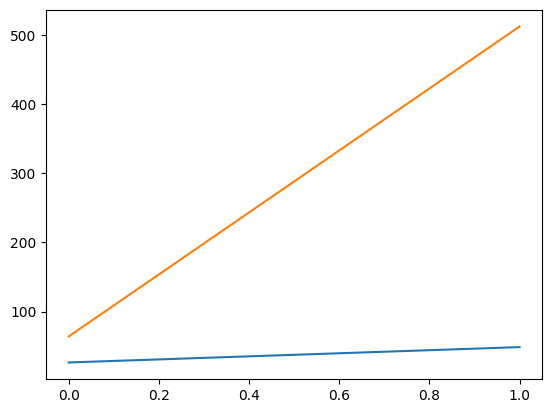

In [19]:
plt.plot(dynamic_cover_time)
plt.plot(theoretical_cover_time)